In [1]:
import pandas as pd
import numpy as np
import math
import random 
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")
import os

In [2]:
def coordinates_on_circle(n):
    """Returns x,y coordinates of points on an unit circle with spacing 2π/n"""
    if type(n)!=int:
        raise Exception("Wrong input: \n the argument must be an integer number of points on the unit circle!")
    x,y = [],[]
    step_angle = 2*math.pi/n
    for i in range(0,n):
        x.insert(len(x),math.cos(i*step_angle))
        y.insert(len(y),math.sin(i*step_angle))
    return x,y

In [3]:
def create_starting_graph(n,r):
    if type(r)!=int:
        raise Exception("Wrong input: \n r must be an integer number of edges between vertices")
    if r>n-1:
        raise Exception("Wrong input: \n r must not exceed n-1!")
    coords = coordinates_on_circle(n)
    
    #create adjacency_matrix as pandas df
    #Initialize adjacency matrix
    adj_mat_df = pd.DataFrame(np.zeros([n,n]),dtype='bool')
    #Make starting connections with pbc
    for i in range(0,n):
        #left
        if(i-r>=0):
            adj_mat_df.iloc[i][i-r:i] = True
        else:
            diff = r-i
            adj_mat_df.iloc[i][0:i] = True
            adj_mat_df.iloc[i][n-diff:n+1] = True
        #right
        if(i+r<n):
            adj_mat_df.iloc[i][i+1:i+r+1] = True #+1 to avoid self loop and up to sym value
        else:
            diff = i+r-n
            adj_mat_df.iloc[i][i+1:n+1] = True
            adj_mat_df.iloc[i][0:diff+1] = True

    return adj_mat_df

In [273]:
def create_strogatz(n, r ,p, place_labels=False ):
    """Plots the graph of the Strogatz model on a unit circle."""
    
    #Procedure to create results folder automatically
    path = os.getcwd()
    results_dir = "/results_WS" 
    try:
        os.mkdir(path+results_dir)
    except OSError:
        print ("Creation of the directory %s failed" % results_dir)
    else:
        print ("Successfully created the directory %s " % results_dir)
    #names for file paths
    name_plot = "/plot_n%d_r%d_p%d.png" %(n,r,p)
    name_csv = "/data_n%d_r%d_p%d.csv" %(n,r,p)
    name_plot_rewired = "/plot_rewired_n%d_r%d_p%d.png" %(n,r,p)
    name_csv_rewired = "/data_rewired_n%d_r%d_p%d.csv" %(n,r,p)
    
    
    #check for errors
    if p>1 or p<0:
        raise Exception("Wrong input: \n p must be in [0,1]")
    coords = coordinates_on_circle(n)
    adj_mat = create_starting_graph(n,r)
    labels_nodes = []
    nodes_coords = coordinates_on_circle(n)
    #figure settings
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,9))
    plt.subplots_adjust(wspace=0.3)
    plt.suptitle("WS(N=%d; 2r = %d), Starting configuration"%(n,2*r),fontsize=25)
    #plot graph
    for i in range(0,n):
        connections_list = adj_mat[adj_mat.iloc[i] == True].index.tolist()
    #print(connections_list) 
        for k in range(0,len(connections_list)):
            ax1.plot([nodes_coords[0][i],nodes_coords[0][connections_list[k]]],[nodes_coords[1][i],nodes_coords[1][connections_list[k]]],linewidth=.5,color='indianred')
    ax1.plot(nodes_coords[0],nodes_coords[1],color='steelblue',ls='none',marker='o',markersize=10,label=labels_nodes)
    ax1.set_title("Graph representation",fontsize=20)
    ax1.set_xticks([])
    ax1.set_yticks([])
    #labels on vertices
    if place_labels==True:
        for i in range(0,n):
            labels_nodes.append("%d"%i)
            ax1.text(nodes_coords[0][i],nodes_coords[1][i],labels_nodes[i],fontsize=15)

            
    #plot adjacency matrix
    ax2.set_xlabel("Edges",fontsize=20)
    ax2.set_ylabel("Vertices",fontsize=20)
    ax2.matshow(adj_mat,cmap='cividis')
    ax2.set_title("Adjacency matrix",fontsize=25)
    
    #save things!
    adj_mat.to_csv(path+results_dir+name_csv,header=False, index=False)
    plt.savefig(path+results_dir+name_plot,dpi=200)
    plt.show()
        
        
    #rewiring! (anticlockwise, for sake of indices)
    
    for i in range(0,n):
        #print("working on row # %d"%(i))
        for j in range(0,2*r):  #for each link to vertex i
            if (random.random()<p): #attempt a rewire
                #performing the rewire
                #    - Choose which of the connected edge to rewire->deleated_edge
                #    - Choose were to rewire it among the available positions->candidates
                #    - Perform the connection/deleate old connection/update mirror adjmat
                
                #choose which edge to remove:
                edge_list = list(adj_mat[adj_mat.iloc[i] == True].index.tolist())
                deleated_edge = random.choice(edge_list)
                
                #chose available position:
                candidates = list(adj_mat[adj_mat.iloc[i] == False].index.tolist())
                candidates.remove(i) #take out self loop
                new_edge = random.choice(candidates)

                #print("candidates list = ",candidates)
                #print("new edge chosen = ",new_edge)
                
                #create new wire
                adj_mat.iloc[i][new_edge]=True
                adj_mat.iloc[new_edge][i]=True

                #deleate old wire
                adj_mat.iloc[i][deleated_edge]=False
                adj_mat.iloc[deleated_edge][i]=False
                

                
    #Copy below diagonal:
    #for i in range(0,n):
    #    for j in range(0,i):
     #       adj_mat.iloc[j][i]=adj_mat.iloc[i][j]
    
    
    #Plot rewired
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,9))
    plt.subplots_adjust(wspace=0.3)    
    plt.suptitle("WS(N=%d; 2r = %d; p = %.3f)"%(n,2*r, p),fontsize=25)

    #plot graph
    for i in range(0,n):
        connections_list = adj_mat[adj_mat.iloc[i] == True].index.tolist()
    #print(connections_list)
        for k in range(0,len(connections_list)):
            ax1.plot([nodes_coords[0][i],nodes_coords[0][connections_list[k]]],[nodes_coords[1][i],nodes_coords[1][connections_list[k]]],linewidth=.5,color='indianred')
    ax1.plot(nodes_coords[0],nodes_coords[1],color='steelblue',ls='none',marker='o',markersize=10,label=labels_nodes)
    ax1.set_title("Graph representation",fontsize=20)
    ax1.set_xticks([])
    ax1.set_yticks([])
    #labels on vertices
    if place_labels==True:
        for i in range(0,n):
            labels_nodes.append("%d"%i)
            ax1.text(nodes_coords[0][i],nodes_coords[1][i],labels_nodes[i],fontsize=15)

            
    #plot adjacency matrix
    ax2.set_xlabel("Edges",fontsize=20)
    ax2.set_ylabel("Vertices",fontsize=20)
    ax2.matshow(adj_mat,cmap='cividis')
    ax2.set_title("Adjacency matrix",fontsize=25)
    
    #save things!
    adj_mat.to_csv(path+results_dir+name_csv_rewired,header=False, index=False)
    plt.savefig(path+results_dir+name_plot_rewired,dpi=200)
    plt.show()

Creation of the directory /results_WS failed


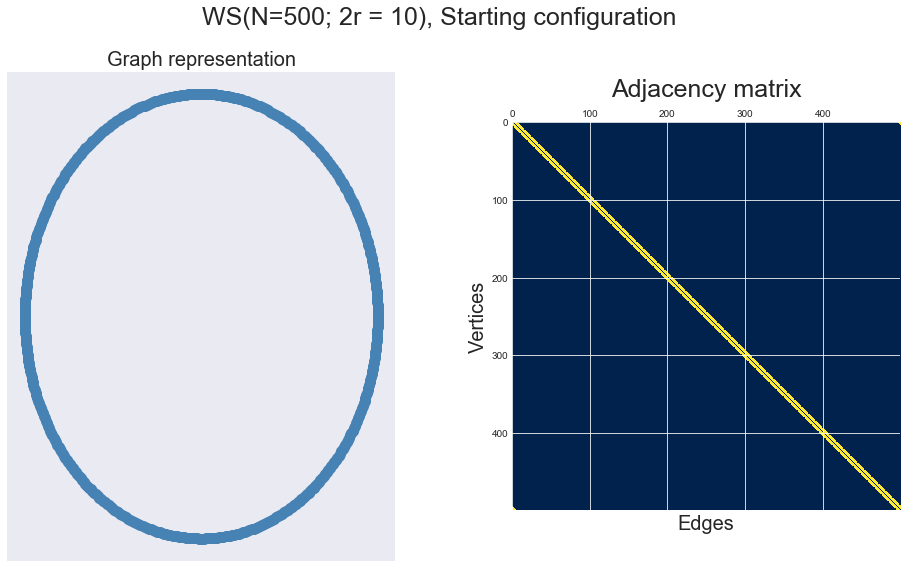

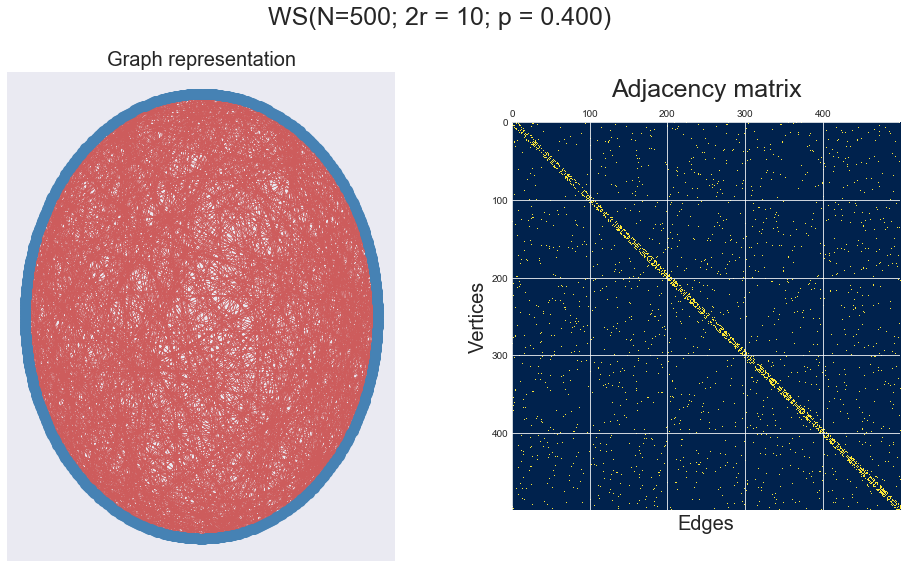

In [274]:
create_strogatz(500,5,.4)